In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (16, 5)
sns.set()

In [3]:
robusta_df = pd.read_html(
    "https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=236"
)[1]

In [4]:
print(robusta_df.head())
print(robusta_df.info())

      Month  Price   Change
0  Aug 2001   0.57        -
1  Sep 2001   0.54  -5.26 %
2  Oct 2001   0.51  -5.56 %
3  Nov 2001   0.52   1.96 %
4  Dec 2001   0.54   3.85 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   235 non-null    object 
 1   Price   235 non-null    float64
 2   Change  235 non-null    object 
dtypes: float64(1), object(2)
memory usage: 5.6+ KB
None


In [5]:
df = robusta_df.copy()
df['Month'] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df = df.set_index('Month')
df.index.freq = 'MS'

df.head()

,Price,Change
Month,,
2001-08-01,0.57,-
2001-09-01,0.54,-5.26 %
2001-10-01,0.51,-5.56 %
2001-11-01,0.52,1.96 %
2001-12-01,0.54,3.85 %


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235 entries, 2001-08-01 to 2021-02-01
Freq: MS
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   235 non-null    float64
 1   Change  235 non-null    object 
dtypes: float64(1), object(1)
memory usage: 5.5+ KB


<AxesSubplot:xlabel='Month'>

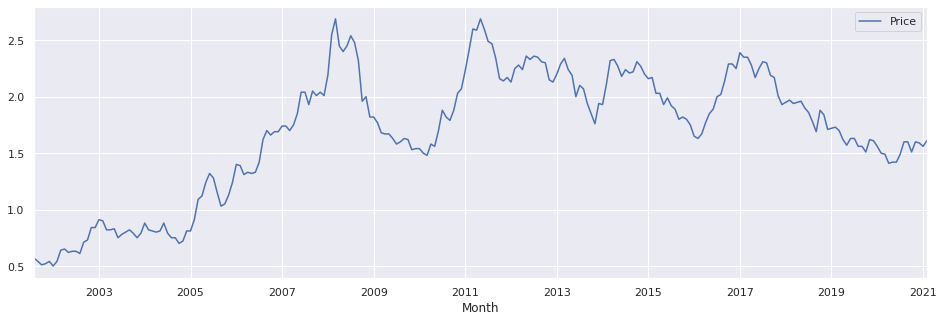

In [7]:
df.plot()

### Fitting AR model

#### Splitting into training and test set

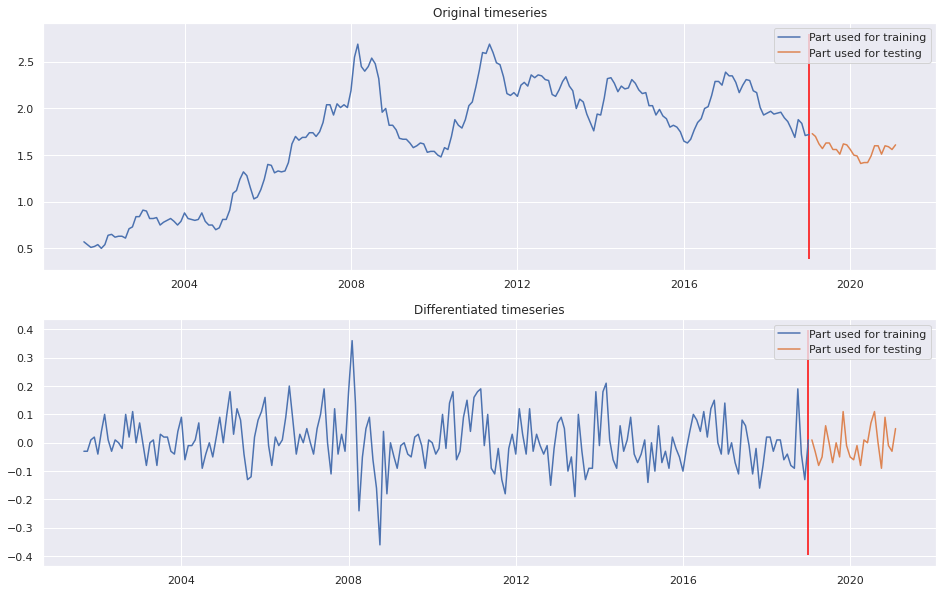

In [8]:
full_df = df.copy()
full_df["Price diff"] = full_df["Price"].diff()

df_train = full_df[:"Jan 2019"]
df_test = full_df["Feb 2019":]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].set_title("Original timeseries")
axes[0].plot(df_train.index, df_train["Price"], label="Part used for training")
axes[0].plot(df_test.index, df_test["Price"], label="Part used for testing")

axes[1].set_title("Differentiated timeseries")
axes[1].plot(df_train.index, df_train["Price diff"], label="Part used for training")
axes[1].plot(df_test.index, df_test["Price diff"], label="Part used for testing")

for ax in axes:
    y_low, y_high = ax.get_ylim()
    ax.vlines("2019-01-01", y_low, y_high, colors="red")
    ax.legend()

### Stationarity test

In [9]:
P_THRESHOLD = 0.05


def adf_test(series):
    _, p_value, *_rest = adfuller(series, autolag="AIC")
    print(
        f"p-value of ADF test is {p_value}, data is "
        f"{'stationary' if p_value < P_THRESHOLD else 'non stationary'}"
    )

In [10]:
print('----- ADF test for original timeseries -----')
adf_test(full_df['Price'])
print()
print('----- ADF test for differianted timeseries -----')
adf_test(full_df['Price diff'].dropna())

----- ADF test for original timeseries -----
p-value of ADF test is 0.18491118958549146, data is non stationary

----- ADF test for differianted timeseries -----
p-value of ADF test is 6.160421033881507e-22, data is stationary


#### Create AR model and fit to the training data

In [11]:
def fit_model(series, order):
    ar_model = ARMA(series, order=(order, 0, 0))
    ar_fitted = ar_model.fit()

    return ar_fitted

In [12]:
def select_best_aic(series, orders_to_check=range(1, 6)):
    best_model, best_order, best_aic = None, None, None
    for order in orders_to_check:
        fitted_model = fit_model(series, order)
        model_aic = fitted_model.aic
        print(f"AR({order}) AIC: {model_aic: .4f}")
        if not best_model or model_aic < best_aic:
            best_model = fitted_model
            best_aic = model_aic
            best_order = order

    print(f"Best model is AR({best_order}) with AIC: {best_aic: .4f}")
    return best_model, best_order

In [13]:
best_model, model_order = select_best_aic(df_train[['Price']])

print("\nBest Model summary for original dataset:")
best_model.summary()

AR(1) AIC: -400.1874


/home/monko/.virtualenvs/machine_learning/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


AR(2) AIC: -412.9912
AR(3) AIC: -411.0144
AR(4) AIC: -409.1465
AR(5) AIC: -407.2469
Best model is AR(2) with AIC: -412.9912

Best Model summary for original dataset:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  210
Model:                     ARMA(2, 0)   Log Likelihood                 210.496
Method:                       css-mle   S.D. of innovations              0.088
Date:                Sat, 01 May 2021   AIC                           -412.991
Time:                        15:11:36   BIC                           -399.603
Sample:                    08-01-2001   HQIC                          -407.579
                         - 01-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5138      0.383      3.954      0.000       0.763       2.264
ar.L1.Price     1.2483      0.066     18.813      0.000       1.118       1.378
ar.L2.Price    -0.2615      0.067     -3.917      0.000      -0.392      -0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0183           +0.0000j            1.0183            0.0000
AR.2            3.7557           +0.0000j            3.7557            0.0000
-----------------------------------------------------------------------------
"""

In [14]:
best_model_diff, model_order_diff = select_best_aic(df_train[['Price diff']].dropna())

print("\nBest Model summary for differentiated dataset:")
best_model.summary()

/home/monko/.virtualenvs/machine_learning/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


AR(1) AIC: -415.5719
AR(2) AIC: -413.6831
AR(3) AIC: -411.7165
AR(4) AIC: -409.7378
AR(5) AIC: -407.9647
Best model is AR(1) with AIC: -415.5719

Best Model summary for differentiated dataset:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  210
Model:                     ARMA(2, 0)   Log Likelihood                 210.496
Method:                       css-mle   S.D. of innovations              0.088
Date:                Sat, 01 May 2021   AIC                           -412.991
Time:                        15:11:36   BIC                           -399.603
Sample:                    08-01-2001   HQIC                          -407.579
                         - 01-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5138      0.383      3.954      0.000       0.763       2.264
ar.L1.Price     1.2483      0.066     18.813      0.000       1.118       1.378
ar.L2.Price    -0.2615      0.067     -3.917      0.000      -0.392      -0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0183           +0.0000j            1.0183            0.0000
AR.2            3.7557           +0.0000j            3.7557            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
def forecast_using_model(model, start, end):
    fitted_values = model.fittedvalues
    forecasted_values = model.predict(start=start, end=end, dynamic=False)

    return forecasted_values

In [16]:
start = len(df_train)
end = len(df_train) + len(df_test)
original_forecasted = forecast_using_model(best_model, start=start, end=end)
diff_forecasted = forecast_using_model(best_model_diff, start=start-1, end=end-1)

In [17]:
orig_forecast_col = f"AR({model_order}) prediction on original timeseries"
diff_forecast_col = f"AR({model_order_diff}) prediction on diffrentiated timeseries"
restored_forecast_col = f"AR({model_order_diff}) prediction restored from diffrentiated timeseries"

full_df[orig_forecast_col] = original_forecasted.reindex_like(full_df)
full_df[diff_forecast_col] = diff_forecasted.reindex_like(full_df)

# Inject last value of known price as starting point of prediction from differences in order to 
# provide starting level of prediction
restored_prediction =  diff_forecasted.reindex_like(full_df)
last_nan_index = np.argmax(np.logical_not(restored_prediction.isna())) - 1
restored_prediction.iloc[last_nan_index] = df_test['Price'][0]
restored_prediction = restored_prediction.cumsum()

# unset injected last price value from prediction 
restored_prediction.iloc[0] = np.nan
full_df[restored_forecast_col] = restored_prediction

<AxesSubplot:title={'center':'Prediction restored from diffrentiated timeseries'}, xlabel='Month'>

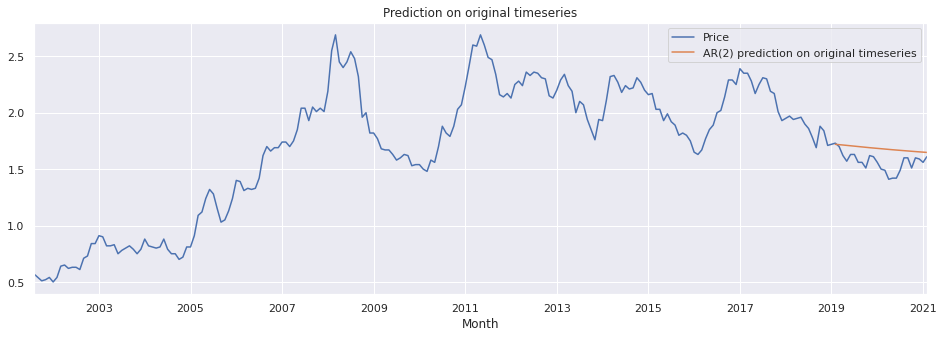

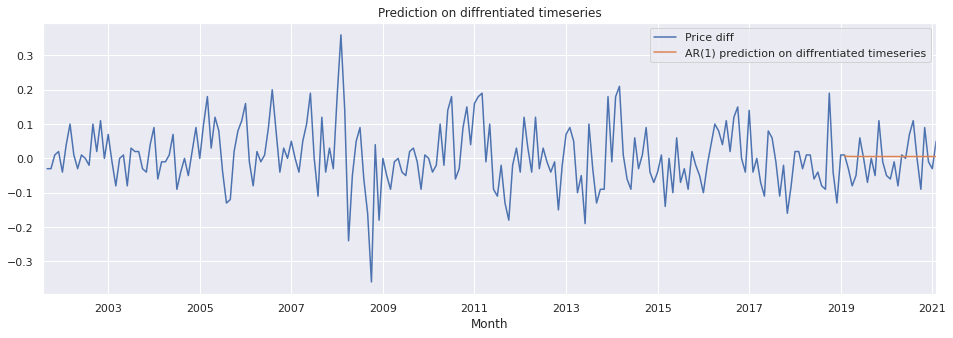

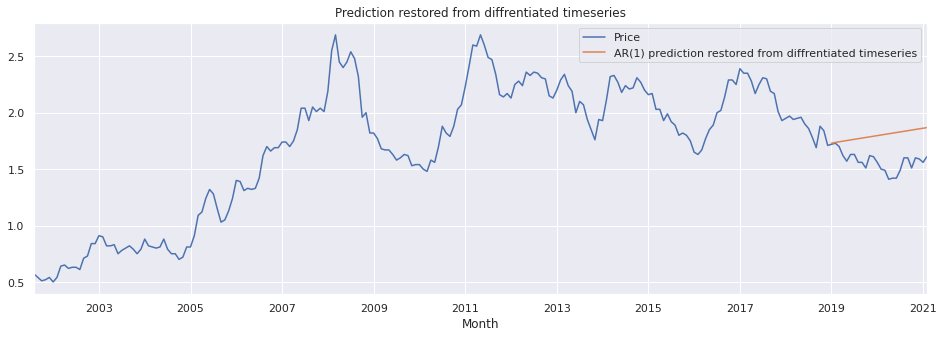

In [18]:
full_df.plot(
    y=["Price", orig_forecast_col],
    figsize=(16, 5),
    title="Prediction on original timeseries",
)
full_df.plot(
    y=["Price diff", diff_forecast_col],
    figsize=(16, 5),
    title="Prediction on diffrentiated timeseries",
)
full_df.plot(
    y=["Price", restored_forecast_col],
    figsize=(16, 5),
    title="Prediction restored from diffrentiated timeseries",
)

In [19]:
print("----- MSE error evaluation on original timeseries -----")
prediction_mse = np.sum((df_test["Price"] - full_df[orig_forecast_col].reindex_like(df_test)).to_numpy() ** 2)
print(f"AR({model_order}) model prediction MSE: {prediction_mse:.2f}")

print("\n----- MSE error evaluation on diffrentiated timeseries -----")
prediction_mse = np.sum((df_test["Price"] - full_df[restored_forecast_col].reindex_like(df_test)).to_numpy() ** 2)
print(f"AR({model_order_diff}) model prediction MSE: {prediction_mse:.2f}")

----- MSE error evaluation on original timeseries -----
AR(2) model prediction MSE: 0.48

----- MSE error evaluation on diffrentiated timeseries -----
AR(1) model prediction MSE: 1.68


----- Residuals statistics for original timeseries -----
AR(2) residuals mean: 0.0020596395737341147
AR(2) residuals std: 0.10931591678745854
p-value of ADF test is 3.3629844650927156e-30, data is stationary

----- Residuals statistics for diffrentiated timeseries -----
AR(1) residuals mean: 4.265272374492658e-05
AR(1) residuals std: 0.08845886267305166
p-value of ADF test is 3.3629844650927156e-30, data is stationary


Text(0.5, 1.0, 'Diffrentiated timeseries residuals')

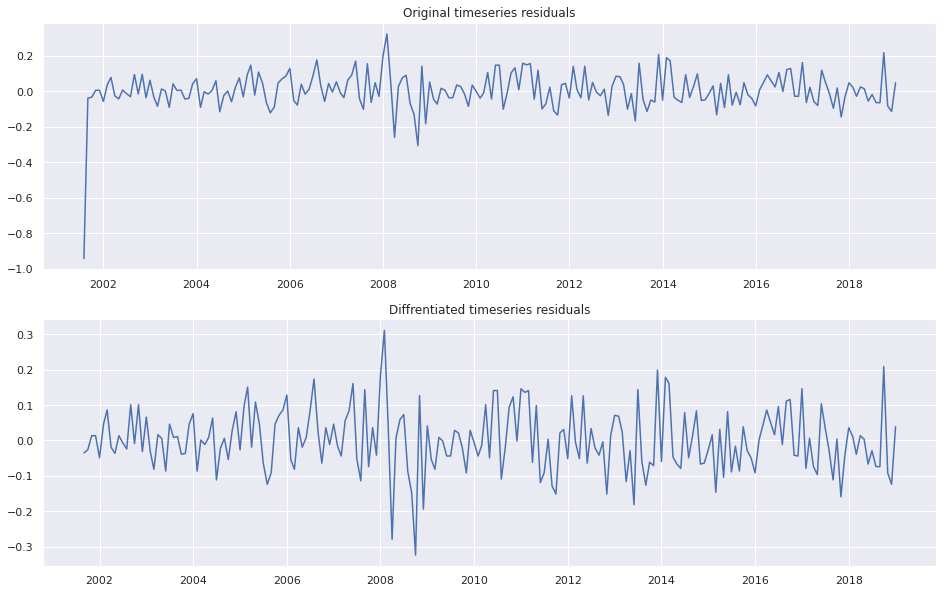

In [20]:
print("----- Residuals statistics for original timeseries -----")
print(f"AR({model_order}) residuals mean: {best_model.resid.mean()}")
print(f"AR({model_order}) residuals std: {best_model.resid.std()}")
adf_test(best_model.resid)

print("\n----- Residuals statistics for diffrentiated timeseries -----")
print(f"AR({model_order_diff}) residuals mean: {best_model_diff.resid.mean()}")
print(f"AR({model_order_diff}) residuals std: {best_model_diff.resid.std()}")
adf_test(best_model.resid)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(best_model.resid)
axes[0].set_title('Original timeseries residuals')

axes[1].plot(best_model_diff.resid);
axes[1].set_title('Diffrentiated timeseries residuals')

### Summary

For this particular timeseries and chosen prediction interval, suprisingly ARMA model trained on the non-stationary dataset performs better job 
when short term prediction is considered. On the other hand, at the end of timeseries there can be seen the beginning of potentially raising trend.
If such a trend occured, then prediction obtained from diffrentiated time series would be able to better prediction in a long term as it forecasts
the raise in price.

Also the mean of the last few years is larger than value before prediction interval, suggesting that the price may be in the periodic decline as such
periods happend before in the last few years, and were followed by later increase in the price.

Due to that, even thought MSE metric is in favor of modeling on original timeseries, the metric capacity to inform about actual quality of prediction is
limited and care must be taken, especially in automatic model selection, to not depend on it too heavily.

It is also worth noticing that although the original data is not stationary, the ADF test score of roughly 0.18, although much larger than threshold of 0.05 is still relatively low. The quality of ARMA based prediction may decrease much more for timeseries with much larger ADF scores.